<a href="https://colab.research.google.com/github/chrisdewey/Movie-Recommender-SVD/blob/main/capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Imports**

In [2]:
%pip install scikit-surprise
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from surprise import SVD, accuracy, Dataset, Reader, dump
from surprise.model_selection import cross_validate, train_test_split
import ipywidgets as widgets
from IPython.display import clear_output, display


%matplotlib inline

     |████████████████████████████████| 11.8 MB 4.3 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1630195 sha256=6076ad5c615cfa2f2c2ea06b557564c579641ac6085302453e5bba615109ec24
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


**Upload CSV files**

In [3]:
from google.colab import files

print('Upload ratings.csv')
ratings_csv = files.upload()
print('Upload movies.csv')
movies_csv = files.upload()

Upload ratings.csv


Saving ratings.csv to ratings.csv
Upload movies.csv


Saving movies.csv to movies.csv


**Prepare the data**

In [30]:
# Read and merge the datasets
df_movies = pd.read_csv('/content/movies.csv',
                        usecols=['movieId', 'title'],
                        dtype={'movieId': 'int32', 'title': 'str'})
df_ratings = pd.read_csv('/content/ratings.csv',
                         usecols=['userId', 'movieId', 'rating', 'timestamp'],
                         dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})  # maybe remove 'timestamp'

df_merged = df_movies.merge(df_ratings, on='movieId')

In [31]:
avg_movie_rating = df_merged.groupby('title')['rating']\
    .mean().sort_values(ascending=False).reset_index().rename(columns={'rating': 'Avg Rating'})

rating_count = df_merged.groupby('title')['rating']\
    .count().sort_values(ascending=True).reset_index().rename(columns={'rating': 'Rating Count'})

df_incl_rc = df_merged.merge(rating_count, left_on='title', right_on='title', how='left')

rating_count_avg = rating_count.merge(avg_movie_rating, on='title')

pd.set_option('display.float_format', lambda x: '%.3f' % x)  # This was normally COMMENTED OUT?? WHY?? GUESS I DON"T NEED IT? DELETE IF BREAKS> REMOVE COMMENT>


**Exploratory Data Analysis**

In [7]:
import seaborn as sns
# import matplotlib.pyplot as plt  # already imported.... SORT IMPORTS... AND COMMENTS lol
sns.set(font_scale=1)
plt.style.use('dark_background')


Text(0, 0.5, 'Rating Count (Scaled)')

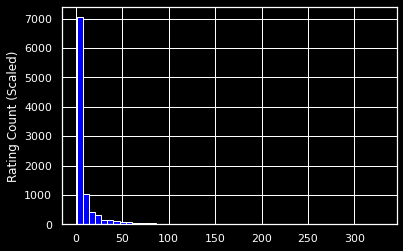

In [8]:
plt.hist(rating_count['Rating Count'], bins=50, color='blue')
plt.ylabel('Rating Count (Scaled)')

In the above histogram, we see that there are many movie which have very few ratings.

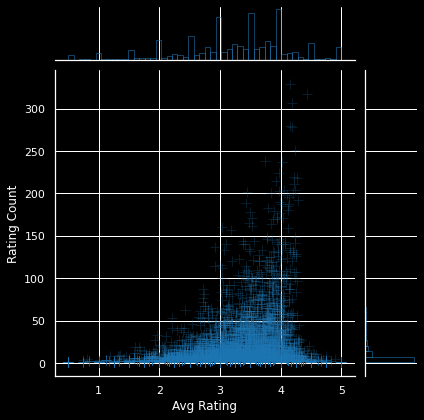

In [8]:
# plt.rcParams["axes.grid"] = False
plot = sns.jointplot(x='Avg Rating', marker='+', y='Rating Count', s=100, marginal_kws=dict(bins=50, fill=False), data=rating_count_avg, alpha=0.3, color='tab:blue')

The above scatterplot shows the relationship between the Average Rating (the x axis) and the Rating Count (the y axis). As we can see, while there are many films with 5 star ratings, virtually none of these have a high rating count. The same holds true for films with extremely low ratings.

To prevent noise in the data which will skew our SVD model, we must establish a usability threshold, whereupon a film, having a high enough rating count, may stay in the dataset for training. Otherwise, the film is removed.

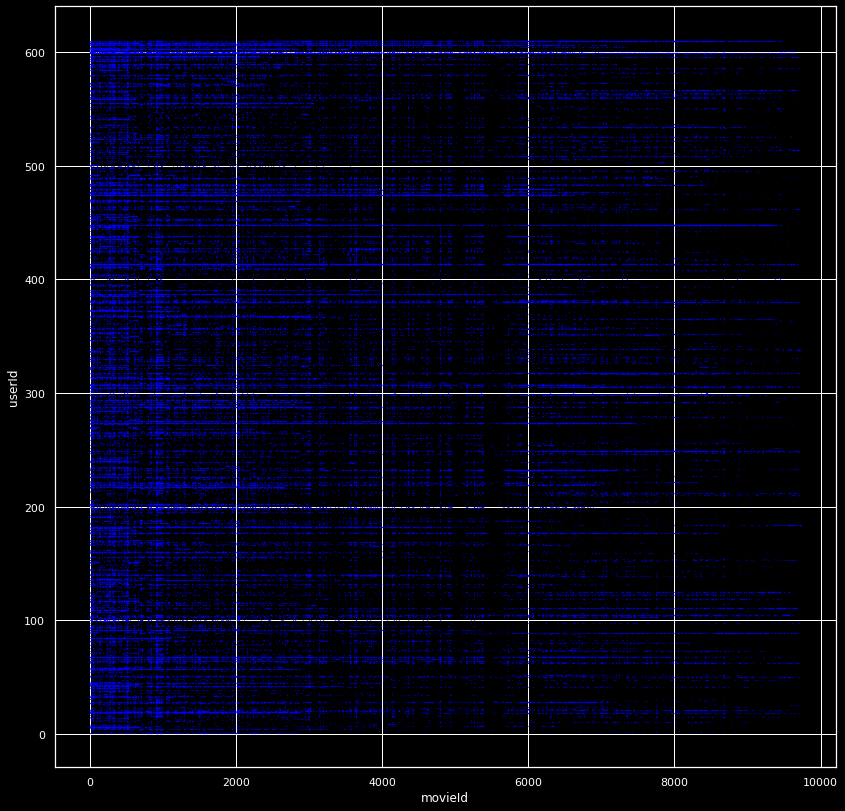

In [18]:
# First we rank the movieId column to portray an accurate spread of data rather than the unique ID number.
df_merged['movieId'] = df_merged['movieId'].rank(method='dense')
# Create Scatter Plot with movieId as x axis and userId as y axis.
df_merged.plot(x='movieId', y='userId', s=.05, kind='scatter', figsize=(14,14), c='blue')

**Establish Threshold**

In [87]:
popularity_threshold = 15
popular_movies = df_incl_rc[df_incl_rc['Rating Count'] >= popularity_threshold]
#popular_movies = df_ratings

# delete this ?
#dropped = df_incl_rc[df_incl_rc['Rating Count'] < popularity_threshold]
#print('dropped:')
#print(dropped.movieId.tolist())

In [88]:
movie_ids = popular_movies.movieId.unique().tolist()
titles = popular_movies.title.unique().tolist()

# Two dicts for quick look-up later on.
title_dict = df_movies.set_index('title').to_dict()['movieId']
reverse_title_dict = df_movies.set_index('movieId').to_dict()['title']

In [89]:
# Format the Dataframe for use in the Scikit Suprise library
df_data = popular_movies.drop(['title', 'timestamp', 'Rating Count'], axis=1)
df_data.rename(columns={'movieId': 'Item', 'userId': 'User', 'rating': 'Rating'}, inplace=True)
df_data.reindex(columns=['User', 'Item', 'Rating'])

,User,Item,Rating
0,1,1,4.000
1,5,1,4.000
2,7,1,4.500
3,15,1,2.500
4,17,1,4.500
...,...,...,...
100589,515,176371,5.000
100590,567,176371,5.000
100591,586,176371,2.500
100592,599,176371,3.500


**User Input**

In [90]:
#user input
movie_select = widgets.Combobox(
    placeholder='Choose a Movie',
    options=titles,
    description='Movie_select:',
    ensure_option=True,
    disabled=False
)
rating_select = widgets.FloatSlider(
    value=2.5,
    min=0.5,
    max=5.0,
    step=0.1,
    description='Rating_select:',
    disabled=False,
    coninuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f'
)
continue_button = widgets.Button(
    description='Add another film',
    disabled=False,
    button_style='',
    tooltip='Click me'
)
exit_button = widgets.Button(
    description='Done adding films',
    disabled=False,
    button_style='',
    tooltip='Click me',
    wait=True
)
add_button = widgets.Button(
    description='Add movie rating'
)

In [91]:
user_preference = dict()

input_widgets = widgets.HBox([movie_select, rating_select])
dash = widgets.VBox([input_widgets, add_button])

def add_vals(b):
  global user_preference
  id = title_dict[movie_select.value]
  user_preference[id] = rating_select.value
  print('Rating Added.')

add_button.on_click(add_vals)
display(dash)

Rating Added.
Rating Added.
Rating Added.
Rating Added.


In [92]:
print('Users film ratings:')
user_preference
# TODO add a user pref default in case user doesn't select anything

Users film ratings:


{1214: 5.0, 8376: 5.0, 8533: 0.5, 51255: 5.0}

In [101]:
user_df = pd.DataFrame(
    {"User": 700, "Item": user_preference.keys(), "Rating": user_preference.values()}
)
df_data = df_data.append(user_df)
df_data

,Item,User,Rating
0,1,1,4.000
1,1,5,4.000
2,1,7,4.500
3,1,15,2.500
4,1,17,4.500
...,...,...,...
3,1214,700,5.000
0,51255,700,5.000
1,8376,700,5.000
2,8533,700,0.500


**Train Model**

In [103]:
min_rating = df_ratings.rating.min()
max_rating = df_ratings.rating.max()

reader = Reader(rating_scale=(min_rating, max_rating))
data = Dataset.load_from_df(df_data[['User', 'Item', 'Rating']], reader)
training_parameters = {'n_epochs': 100, 'lr_all': 0.005, 'reg_all': 0.08}

print("Creating trainset:")
trainset = data.build_full_trainset()
print("done.")

start = datetime.now()
print("Training Started:")
# from surprise import SVDpp
# from surprise.model_selection import train_test_split
algo = SVD(n_epochs = training_parameters['n_epochs'], lr_all = training_parameters['lr_all'], reg_all = training_parameters['reg_all'])
# algo = SVDpp()

# trainset, testset = train_test_split(data, test_size=.25)

algo.fit(trainset)

end = datetime.now()
print("done.\t\t time: ", (end-start).seconds, "seconds")

Creating trainset:
done.
Training Started:
done.		 time:  22 seconds


In [98]:
# DELETE THIS
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

KeyboardInterrupt: ignored

In [ ]:
# Pickle The Model (called dump in Suprise)

In [ ]:
model_file = "/content/trained_model.pickle"
import os
file_name = os.path.expanduser(model_file)
dump.dump(file_name, algo=algo)

In [ ]:
# Load The Model

In [ ]:
def load_model(model_file):
    print (">> Loading dump")
    file_name = os.path.expanduser(model_file)
    _, loaded_model = dump.load(file_name)
    print (">> Loaded dump")
    return loaded_model

**Predict**

In [112]:
model_file = "/content/trained_model.pickle"

user_preds = dict()

def recommend(user, n):
  """
  user == the user to return predictions for.
     n == the number of recommendations to return.
  """
  uid = user
  
  rated_films = df_data.loc[df_data["User"] == user, "Item"]
  unknown = np.setdiff1d(movie_ids, rated_films)

  print(len(rated_films))
  print(len(unknown))
  #loaded_model = load_model(model_file)
  """
  rating = prediction.est
  details = prediction.details
  uid = prediction.uid
  iid = prediction.iid
  boolval = prediction.r_ui
  """
  #s = 0
  # OKAY so try as ints first, then strings. trained on ints instead or smthg?
  for film in unknown:
    iid = film

    prediction = algo.predict(uid, iid)

    user_preds[film] = prediction.est

  #print(user_preds)
  sorted_user_preds = sorted(user_preds.items(), key=lambda x:-x[1])[:n]
  #print(s)
  #print(popular_movies)
  return sorted_user_preds

x = recommend(700, 10)
# x = algo.predict(1, 444, verbose=True)
#print(x.iid)

print('Recommendations:')
for i in range(len(x)):
  print(i+1, end="")
  print('. ', end="")
  print(reverse_title_dict[x[i][0]], end="")
  print(', ', end="")
  print("{:.2f}".format(x[i][1]))


12
1649
Recommendations:
1. Lord of the Rings: The Fellowship of the Ring, The (2001), 4.84
2. Lord of the Rings: The Return of the King, The (2003), 4.83
3. Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981), 4.81
4. Third Man, The (1949), 4.81
5. Hoop Dreams (1994), 4.80
6. Star Wars: Episode IV - A New Hope (1977), 4.77
7. Star Wars: Episode V - The Empire Strikes Back (1980), 4.76
8. Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964), 4.70
9. Blade Runner (1982), 4.70
10. Strangers on a Train (1951), 4.68
